### Allele-specific expression

RNA sequencing can distinguish mRNAs expressed from from different copies of genes on homologous chromosomes when single-nucleotide polymorphisms (perhaps silent) distinguish the two alleles. 

Linkage between these distinctive SNPs and _cis_-regulatory sequences can provide information on regulatory variation within a shared cellular context.

In the example below, the maternally derived copy of the gene has a `TGC` serine codon at the 2nd position and a functioning enhancer. The paternally derived allele has a `TGT` serine codon and a mutated enhancer.

```
Maternal: ----enhancer----ATGTGCACT...

Paternal: ----exhxnxer----ATGTGTACT...
```

Because the paternal enhancer is mutated, we would expect most mRNA to derive from the maternal allele and thus most RNA-Seq reads should have a `C` rather than a `T`.

### Null hypothesis testing

The _null hypothesis_ in allele-specific expression analysis is that the alleles are expressed equally, and so each read is equally likely to be derived from each allele.

Our actual data comes from _counting_ how many RNA-seq reads have the maternally-derived `C` variant and how many have the paternally-derived `T` variant.

We want to build a complex probabilistic model of these read counts from a simpler model:
* each read is equally likely to be a `C` or a `T`
* each read is independent

We will use this to ask — if we see an imbalance between maternally- and paternally-derived alleles — whether this imbalance is very unlikely to occur in our null model that reads are equally likely to come from each allele.

We will do this in two ways: first we will actually perform random sampling, and second we will use a mathematical formula that fits this kind of model.

#### Random sampling

We begin by importing pandas

In [1]:
import pandas as pd

Now we create a pandas `Series` object containing the two possible alleles.

The _values_ will be the two possible genotypes and the _indexes_ will help us remember that one variant is maternally-derived and the other paternally-derived.

In [3]:
alleles = pd.Series(['C', 'T'], index=['mat', 'pat'])
alleles

mat    C
pat    T
dtype: object

We can use the `sample` method to take one (by default) or more (using the `n=` parameter) random allele choices.

When we're taking more than one random sample, we also need to use the `replace=True` parameter because the default is sampling without replacement, but sampling with replacement — that is, being able to randomly choose a given allele more than once — better models gene expression.

We can then use the `value_counts` method to count up the number of maternal and paternal alleles seen across the randomly sampled reads.

In [15]:
alleles.sample(n=8, replace=True).value_counts()['T']

3

Next we want to run this sampling procedure 10,000 times and count up how often we see zero `T` alleles out of eight reads, how often we see one `T` allele, and so forth.

To do this, we will:
* write a `for` loop to run 10,000 times
* sample alleles from 8 reads
* count `T` alleles in our sample (use the `get` method with default value 0)
* add the count of `T` alleles to a list of sample counts
* after generating all of our sample counts, convert them to a `Series` and find the value counts.

In [18]:
sample_paternal_counts = []
for _ in range(0,10000):
    paternal_count = alleles.sample(n=8, replace=True).value_counts().get('T', 0)
    sample_paternal_counts.append(paternal_count)
paternal_freqs = pd.Series(sample_paternal_counts).value_counts()
paternal_freqs

4    2748
3    2172
5    2145
6    1161
2    1092
7     309
1     287
8      44
0      42
dtype: int64

We can divide these by the total number of random samples we generated in order to get a normalized probability.

We can also sort them for easier reading using `sort_index`

In [20]:
paternal_probs = paternal_freqs / 10000
paternal_probs = paternal_probs.sort_index()
paternal_probs

0    0.0042
1    0.0287
2    0.1092
3    0.2172
4    0.2748
5    0.2145
6    0.1161
7    0.0309
8    0.0044
dtype: float64

We can compute the probability of seeing _exactly_ 2 paternally-derived alleles

In [21]:
paternal_probs[2]

0.1092

We can also compute the probability of seeing _no more than_ 2 paternally-derived alelles

In [23]:
paternal_probs[0:3].sum()

0.1421

Lastly, we'll use matplotlib to plot this distribution.

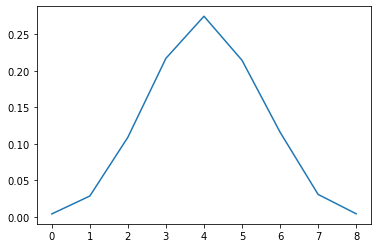

In [24]:
import matplotlib.pyplot as plt
plt.plot(paternal_probs)

Later, we'll want to look at random samples taken with different numbers of reads. We'll also want to control the number of samples we take. To simplify this, we'll package up all of our random sampling code into a function that has parameters to control the number of reads in each sample and the total number of samples.

In [31]:
# We didn't get to this in class


def sample_paternal_probs(nread=8, nsample=10000):
    alleles = pd.Series(['C', 'T'])
    sample_counts = []
    for _ in range(0, nsample):
        maternal_count = alleles.sample(n = nread, replace=True).value_counts().get('T', 0)
        sample_counts.append(maternal_count)
    sample_freqs = pd.Series(sample_counts).value_counts().sort_index()
    return(sample_freqs / nsample)



To test our function, we will sample probabilities for 16 reads.

In [25]:
sample_paternal_counts = []
for _ in range(0,10000):
    paternal_count = alleles.sample(n=16, replace=True).value_counts().get('T', 0)
    sample_paternal_counts.append(paternal_count)
paternal_freqs = pd.Series(sample_paternal_counts).value_counts()
paternal_probs_16 = paternal_freqs / 10000
paternal_probs_16 = paternal_probs_16.sort_index()
paternal_probs_16

2     0.0025
3     0.0075
4     0.0308
5     0.0649
6     0.1212
7     0.1806
8     0.1981
9     0.1747
10    0.1195
11    0.0628
12    0.0274
13    0.0080
14    0.0018
15    0.0002
dtype: float64

#### The binomial distribution

Our probabilistic model of counting up the results of several independent trials is very common in probability. From a mathematical perspective, it's the same as counting the number of heads that come up out of _N_ total coin tosses.

This number follows a _binomial distribution_. We can compute
$$P(\;k\;\text{heads out of}\;N\;\text{coin tosses})$$
using
```
binom.pmf(k, N, 0.5)
```
The `0.5` parameter here is the probability of a head for each coin toss — the `binom.pmf` function can compute probabilities for a _biased_ coin where the chances of a head are not exactly $\frac{1}{2}$.

The `binom.pmf` function comes from the `binom` module in `scipy.stats`. We'll import this and then compute a probability under the binomial model for exactly 2 paternally-derived reads out of 8 coin tosses.

In [26]:
from scipy.stats import binom
binom.pmf(2, 8, 0.5)

0.10937500000000004

This binomial probability is very close to the value we got by random sampling!

We can also construct the whole table of binomial probabilities by using a `range()` for the $k$ parameter.

In [29]:
binom_probs_8 = pd.Series(binom.pmf(range(0, 9), 8, 0.5), index=range(0,9))
binom_probs_8

0    0.003906
1    0.031250
2    0.109375
3    0.218750
4    0.273437
5    0.218750
6    0.109375
7    0.031250
8    0.003906
dtype: float64

We can plot the binomial probabilities and the random sampling probabilities on the same graph and compare them.

We can also control the plot styles: I'll use the `'b-'` parameter for blue lines and the `'ro'` parameter for red dots. 

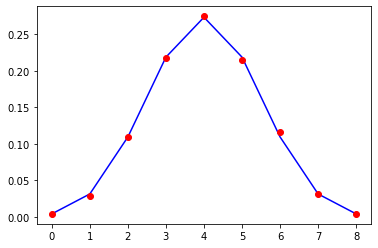

In [30]:
plt.plot(binom_probs_8, 'b-')
plt.plot(paternal_probs, 'ro')

#### More reads give more certainty

In this binomial model — and in other more realistic models of deep sequencing data — greater sequencing depth gives more statistical power to reject the null hypothesis.

To see this effect in action for the binomial model of allele-specific expression, consider two possibilities:
* No more than one quarter of 8 reads are paternally-derived
* No more than one quarter of 16 reads are paternally-derived

In both cases, the _magnitude_ of the paternal vs maternal skew is 1:3.

In [32]:
# We didn't get to this in class
print('8 reads: ' + str(binom.pmf(range(0,3), 8, 0.5).sum()))
print('16 reads: ' + str(binom.pmf(range(0, 5), 16, 0.5).sum()))


8 reads: 0.14453125000000003
16 reads: 0.0384063720703125
